# Tarea Calificada: Perfilamiento de Datos Infraestructura Visible

## 1. Configuración de Librerías y PySpark
    
En este documento se presenta el proceso realizado para la exploración, preprocesamiento y persistencia de datos con PySpark

Se inicia importando las librerías necesarias:

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan, when, count, col

In [2]:
import os 
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /usr/share/java/mariadb-java-client-2.5.3.jar pyspark-shell'

In [3]:
#Configuración de la sesión
spark_context = SparkContext()
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

## 2. Exploración

### 2.1. Importar los datos

Se importan los datos a través de una estructura de DataFrame

Primero importamos los datos de la base de datos "aeropuertos" y luego de la base de datos "vuelos"

In [4]:
aerop_wwwimporter = spark.read.load("aeropuertos.csv",format="csv", sep=",", inferSchema="true", header="true")
aerop = aerop_wwwimporter

In [5]:
vuelos_wwwimporter = spark.read.load("vuelos.csv",format="csv", sep=",", inferSchema="true", header="true")
vuelos = vuelos_wwwimporter

### 2.2. Resumen de las columnas

Inspeccionamos las columnas de cada archivo para entender las variables y tipos de datos

In [6]:
columnas_vuelos = str(vuelos.schema)
columnas_vuelos.split("StructField")

['StructType(List(',
 '(ano,IntegerType,true),',
 '(mes,IntegerType,true),',
 '(origen,StringType,true),',
 '(destino,StringType,true),',
 '(tipo_equipo,StringType,true),',
 '(tipo_vuelo,StringType,true),',
 '(trafico,StringType,true),',
 '(empresa,StringType,true),',
 '(vuelos,StringType,true),',
 '(sillas,StringType,true),',
 '(carga_ofrecida,DoubleType,true),',
 '(pasajeros,StringType,true),',
 '(carga_bordo,DoubleType,true)))']

En relación a las fuentes consultadas se concluye en la exploración inicial que:
- Requieren preparación ya que se identifica que tienen valores nulos que hay que tratar
- Es posible integrar las fuentes a través del código IATA y el código de destino
- En la primera fuente "aeropuertos" encontramos la información general, especificaciones y características técnicas de operación de los aeropuertos junto con el número de vuelos registrado en el último año en ese aeropuerto como punto de origen
- En la segunda fuente encontramos la información de vuelos con sus capacidades disponibles y ocupadas tanto en pasajeros como en carga

In [7]:
max_ano = vuelos.agg({'ano': 'max'}).collect()[0][0]
min_ano = vuelos.agg({'ano': 'min'}).collect()[0][0]
vuelos.count(),max_ano,min_ano, aerop.count()

(67599, 2013, 2010, 292)

En relación a la cantidad de registros y periodo de tiempo encontramos para cada fuente: 
- Vuelos: 67599 registros que se encuentran en un rango de fechas del 2010 al 2013
- Aeropuertos: 292 registros. No existe una columna que indique el periodo de tiempo. Sin embargo, en la descripción de variables suministrada por el cliente se indica que el número total de vuelos registrado es del último año

In [8]:
aerop_colnames = aerop.columns[0:]

for col in aerop_colnames:
    col_count = aerop.select(col).distinct().count()
    col_total = aerop.select(col).count()
    print('variable {0},count {1}, cantidad {2}'.format(col, col_count, col_total))

variable _c0,count 213, cantidad 292
variable sigla,count 212, cantidad 292
variable iata,count 62, cantidad 292
variable nombre,count 206, cantidad 292
variable municipio,count 122, cantidad 292
variable departamento,count 30, cantidad 292
variable categoria,count 4, cantidad 292
variable latitud,count 212, cantidad 292
variable longitud,count 212, cantidad 292
variable propietario,count 121, cantidad 292
variable explotador,count 103, cantidad 292
variable longitud_pista,count 98, cantidad 292
variable ancho_pista,count 22, cantidad 292
variable pbmo,count 37, cantidad 292
variable elevacion,count 183, cantidad 292
variable resolucion,count 166, cantidad 292
variable fecha_construccion,count 194, cantidad 292
variable fecha_vigencia,count 56, cantidad 292
variable clase,count 15, cantidad 292
variable tipo,count 4, cantidad 292
variable numero_vuelos_origen,count 187, cantidad 292
variable gcd_departamento,count 30, cantidad 292
variable gcd_municipio,count 122, cantidad 292


Para la fuente aeropuertos, encontramos que no tenemos variables con registros únicos, por tanto tampoco existe una variable que nos permita identificar los datos por un ID único.

In [9]:
vuelos_colnames = vuelos.columns[0:]

for col in vuelos_colnames:
    col_count = vuelos.select(col).distinct().count()
    col_total = vuelos.select(col).count()
    print('variable {0}, unicos {1}, cantidad {2}'.format(col, col_count,col_total))

variable ano, unicos 4, cantidad 67599
variable mes, unicos 12, cantidad 67599
variable origen, unicos 111, cantidad 67599
variable destino, unicos 110, cantidad 67599
variable tipo_equipo, unicos 94, cantidad 67599
variable tipo_vuelo, unicos 4, cantidad 67599
variable trafico, unicos 2, cantidad 67599
variable empresa, unicos 71, cantidad 67599
variable vuelos, unicos 611, cantidad 67599
variable sillas, unicos 5810, cantidad 67599
variable carga_ofrecida, unicos 9649, cantidad 67599
variable pasajeros, unicos 7894, cantidad 67599
variable carga_bordo, unicos 10289, cantidad 67599


En relación a la fuente vuelos, encontramos también que no tenemos ninguna variable con registro único que nos identifique cada registro. Sin embargo la información de la columna origen podría ser útil para consolidar la información en función de lo que se requiere para los análisis.

In [10]:
columnas_aerop = str(aerop.schema)
columnas_aerop.split("StructField")

['StructType(List(',
 '(_c0,IntegerType,true),',
 '(sigla,StringType,true),',
 '(iata,StringType,true),',
 '(nombre,StringType,true),',
 '(municipio,StringType,true),',
 '(departamento,StringType,true),',
 '(categoria,StringType,true),',
 '(latitud,DoubleType,true),',
 '(longitud,DoubleType,true),',
 '(propietario,StringType,true),',
 '(explotador,StringType,true),',
 '(longitud_pista,DoubleType,true),',
 '(ancho_pista,DoubleType,true),',
 '(pbmo,StringType,true),',
 '(elevacion,DoubleType,true),',
 '(resolucion,StringType,true),',
 '(fecha_construccion,StringType,true),',
 '(fecha_vigencia,StringType,true),',
 '(clase,StringType,true),',
 '(tipo,StringType,true),',
 '(numero_vuelos_origen,StringType,true),',
 '(gcd_departamento,IntegerType,true),',
 '(gcd_municipio,IntegerType,true)))']

Se requiere realizar algunas conversiones en los tipos de datos de las siguientes variables: 

AEROPUERTOS

- latitud y longitud de tipo DoybleType y requerimos convertirlas a decimal
- longitud de pista, ancho de pista, elevación de tipo DoybleType y requerimos convertirlas a entero
- pbmo y número de vuelos origen de tipo String y requerimos convertirlas a entero

VUELOS

Las siguientes variables de tipo string se requieren converitr a tipo integer:
- vuelos, sillas y pasajeros

Y las siguientes a tipo decimal:

- carga_ofrecida y carga_bordo

In [11]:
from pyspark.sql.types import IntegerType
aerop = aerop.withColumn("latitud",aerop["latitud"].cast(FloatType()))
aerop = aerop.withColumn("longitud",aerop["longitud"].cast(FloatType()))
aerop = aerop.withColumn("longitud_pista",aerop["longitud_pista"].cast(IntegerType()))
aerop = aerop.withColumn("ancho_pista",aerop["ancho_pista"].cast(IntegerType()))
aerop = aerop.withColumn("elevacion",aerop["elevacion"].cast(IntegerType()))
aerop = aerop.withColumn("pbmo",aerop["pbmo"].cast(IntegerType()))
aerop = aerop.withColumn("numero_vuelos_origen",aerop["numero_vuelos_origen"].cast(IntegerType()))


vuelos = vuelos.withColumn("vuelos",vuelos["vuelos"].cast(IntegerType()))
vuelos = vuelos.withColumn("sillas",vuelos["sillas"].cast(IntegerType()))
vuelos = vuelos.withColumn("pasajeros",vuelos["pasajeros"].cast(IntegerType()))
vuelos = vuelos.withColumn("carga_ofrecida",vuelos["carga_ofrecida"].cast(IntegerType()))
vuelos = vuelos.withColumn("carga_bordo",vuelos["carga_bordo"].cast(IntegerType()))

Empleamos el método <i>summary</i> para hacer un resumen del DataFrame, mostrando información como el número de valores, el promedio y la desviación estándar. 

In [12]:
aerop.select('latitud','longitud', 'longitud_pista','ancho_pista','pbmo','elevacion','numero_vuelos_origen','gcd_departamento','gcd_municipio').summary().show()

+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+-----------------+------------------+
|summary|           latitud|          longitud|   longitud_pista|       ancho_pista|             pbmo|         elevacion|numero_vuelos_origen| gcd_departamento|     gcd_municipio|
+-------+------------------+------------------+-----------------+------------------+-----------------+------------------+--------------------+-----------------+------------------+
|  count|               292|               292|              292|               292|              237|               292|                 221|              292|               292|
|   mean| 5.543335635572264|-73.24611384248081| 962.445205479452|17.633561643835616|5683.341772151899|1073.3082191780823|  185576.36199095022|63.03767123287671| 63341.63698630137|
| stddev|2.3826685530856735| 2.296073972909863|540.0191104015921|10.356164406912008|9669.19441180984

In [13]:
vuelos.select('vuelos', 'sillas', 'pasajeros','carga_ofrecida','carga_bordo').summary().show()

+-------+------------------+------------------+-----------------+------------------+------------------+
|summary|            vuelos|            sillas|        pasajeros|    carga_ofrecida|       carga_bordo|
+-------+------------------+------------------+-----------------+------------------+------------------+
|  count|             66017|             63582|            64116|             67599|             67599|
|   mean|14.263735098535225|1133.1225346796264|911.7284297211304|46758.481959792305| 5325.660897350553|
| stddev| 40.19851542146546| 4468.301901592545| 3613.76621059051|230667.33259801066|23415.893534730683|
|    min|                 1|                 0|                0|                 0|                 0|
|    25%|                 1|                 0|                2|                 0|                 0|
|    50%|                 2|                 0|                8|                 0|               110|
|    75%|                 9|               240|              184

### 2.3. Otras opciones de exploración

Ahora exploraremos los archivos con agregaciones y tablas de pivotes.

Para poder Visualizar el número de pasajeros transportados en un rango de fechas de aeropuertos Nacionales de Colombia

In [13]:
datos_nacionales = vuelos.groupBy('origen').agg({'pasajeros': 'sum','carga_bordo':'sum'})
datos_nacionales.show()

+------+--------------+----------------+
|origen|sum(pasajeros)|sum(carga_bordo)|
+------+--------------+----------------+
|   9CL|             1|             100|
|   9AB|           461|            8554|
|   9CG|           350|            4785|
|   OTU|           112|           12655|
|   NVA|        994296|         1905660|
|   RVE|         17449|          415172|
|   9BB|           272|            3527|
|   9BI|             8|             100|
|   ACD|           463|           28306|
|   YPP|             1|               1|
|   PUU|        160717|          652179|
|   URR|            18|               0|
|   A01|            14|            1822|
|   VGP|         60470|          338218|
|   ARQ|             9|             310|
|   AFI|            26|             218|
|   7HB|           193|            1611|
|   9CZ|             1|               0|
|   PVA|        179305|         1819611|
|   IGO|            18|             585|
+------+--------------+----------------+
only showing top

Exploremos ahora 
- 1. La cantidad total de vuelos por mes y año
- 2. La cantidad total de vuelos anuales que salieron desde cada aeropuerto de origen

In [14]:
vuelos.groupBy('mes').pivot('ano').count().show()
vuelos.groupBy('origen').pivot('ano').count().show()

+---+----+----+----+----+
|mes|2010|2011|2012|2013|
+---+----+----+----+----+
| 12|1521|1433|1618|1848|
|  1| 929|1331|1253|1489|
|  6|1373|1547|1572|1427|
|  3|1182|1313|1423|1628|
|  5|1297|1270|1517|1482|
|  9|1265|1305|1355|1623|
|  4|1264|1355|1265|1414|
|  8|1224|1462|1459|1642|
|  7|1299|1319|1440|1551|
| 10|1347|1497|1570|1663|
| 11|1229|1293|1395|1644|
|  2|1090|1290|1364|1522|
+---+----+----+----+----+

+------+----+----+----+----+
|origen|2010|2011|2012|2013|
+------+----+----+----+----+
|   9CL|null|   1|null|null|
|   9AB|  11|  10|null|   1|
|   9CG|   2|  23|  32|  18|
|   OTU|   2|   7|  19|  14|
|   NVA| 645| 626| 635| 735|
|   RVE|  59| 104| 103| 158|
|   9BB|null|   1|  36|  37|
|   9BI|null|   3|   2|null|
|   ACD|  21|  19|  19|  17|
|   YPP|null|null|   1|null|
|   PUU| 265| 279| 235| 309|
|   URR|null|null|null|   2|
|   A01|null|null|null|  13|
|   VGP| 162| 219| 223| 236|
|   ARQ|null|null|null|   5|
|   AFI|null|null|   2|null|
|   7HB|null|null|  12|  45|
|  

## 3. Preprocesamiento

### 3.0 Eliminar Registros Duplicados

En la fuente aeropuertos observamos que contamos con algunos registros duplicados. Razón por la cual se requiere depurar estos registros de manera que tengamos una única información para cada aeropuerto

In [21]:
aerop = aerop.dropDuplicates(subset=['_c0'])
for col in aerop_colnames:
    col_count = aerop.select(col).distinct().count()
    col_total = aerop.select(col).count()
    print('variable {0},count {1}, cantidad {2}'.format(col, col_count, col_total))

variable _c0,count 213, cantidad 213
variable sigla,count 212, cantidad 213
variable iata,count 62, cantidad 213
variable nombre,count 206, cantidad 213
variable municipio,count 122, cantidad 213
variable departamento,count 30, cantidad 213
variable categoria,count 4, cantidad 213
variable latitud,count 212, cantidad 213
variable longitud,count 212, cantidad 213
variable propietario,count 121, cantidad 213
variable explotador,count 103, cantidad 213
variable longitud_pista,count 98, cantidad 213
variable ancho_pista,count 22, cantidad 213
variable pbmo,count 37, cantidad 213
variable elevacion,count 183, cantidad 213
variable resolucion,count 166, cantidad 213
variable fecha_construccion,count 147, cantidad 213
variable fecha_vigencia,count 40, cantidad 213
variable clase,count 15, cantidad 213
variable tipo,count 4, cantidad 213
variable numero_vuelos_origen,count 130, cantidad 213
variable gcd_departamento,count 30, cantidad 213
variable gcd_municipio,count 122, cantidad 213


### 3.1. Reemplazar valores nulos

Identifiquemos la cantidad de valores nulos que tenemos en cada fuente: 

In [22]:
aerop.select([count(when(isnan(c), c)).alias(c) for c in aerop.columns]).show()

+---+-----+----+------+---------+------------+---------+-------+--------+-----------+----------+--------------+-----------+----+---------+----------+------------------+--------------+-----+----+--------------------+----------------+-------------+
|_c0|sigla|iata|nombre|municipio|departamento|categoria|latitud|longitud|propietario|explotador|longitud_pista|ancho_pista|pbmo|elevacion|resolucion|fecha_construccion|fecha_vigencia|clase|tipo|numero_vuelos_origen|gcd_departamento|gcd_municipio|
+---+-----+----+------+---------+------------+---------+-------+--------+-----------+----------+--------------+-----------+----+---------+----------+------------------+--------------+-----+----+--------------------+----------------+-------------+
|  0|    0| 150|     0|        0|           0|        0|      0|       0|          2|         0|             0|          0|   0|        0|         3|                 0|           164|    0|   0|                   0|               0|            0|
+---+-----+-

Para la variable iata que representa el código del aeropuerto completar los datos a través de categorízaciones no es una solución óptima, se solicita al cliente revisar la posibilidad de completar la información. En caso de no ser viable, se propone eliminar estos registros. 

Para las variables numéricas, se procederá a completar la información con promedios para cada columna

In [23]:
vuelos.select([count(when(isnan(c), c)).alias(c) for c in vuelos.columns]).show()

+---+---+------+-------+-----------+----------+-------+-------+------+------+--------------+---------+-----------+
|ano|mes|origen|destino|tipo_equipo|tipo_vuelo|trafico|empresa|vuelos|sillas|carga_ofrecida|pasajeros|carga_bordo|
+---+---+------+-------+-----------+----------+-------+-------+------+------+--------------+---------+-----------+
|  0|  0|     0|      0|          0|         0|    894|      0|     0|     0|             0|        0|          0|
+---+---+------+-------+-----------+----------+-------+-------+------+------+--------------+---------+-----------+



Se observa que contamos con 894 registros nulos en la columna tráfico, información clave en el análisis dado que nos indica si el vuelo es nacional o internacional. Por lo cual se procederá a solicitar esta información al cliente.

En relación a la columna pasajeros, se usará el criterio de promedio para completar los faltantes.

A continuación, se reemplazarán los valores nulos de la columna por el valor de su media para las variables numéricas.

In [24]:
media_pbmo = aerop.agg({'pbmo': 'mean'}).collect()[0][0]
media_n_v_origen = aerop.agg({'numero_vuelos_origen': 'mean'}).collect()[0][0]
aerop =  aerop.fillna({'pbmo': media_pbmo})
aerop =  aerop.fillna({'numero_vuelos_origen': media_n_v_origen})

In [25]:
media_vuelos = vuelos.agg({'vuelos': 'mean'}).collect()[0][0]
media_sillas = vuelos.agg({'sillas': 'mean'}).collect()[0][0]
media_pasajeros = vuelos.agg({'pasajeros': 'mean'}).collect()[0][0]
media_carga_ofrecida = vuelos.agg({'carga_ofrecida': 'mean'}).collect()[0][0]
media_carga_bordo = vuelos.agg({'carga_bordo': 'mean'}).collect()[0][0]
vuelos =  vuelos.fillna({'vuelos': media_vuelos})
vuelos =  vuelos.fillna({'sillas': media_sillas})
vuelos =  vuelos.fillna({'pasajeros': media_pasajeros})
vuelos =  vuelos.fillna({'carga_ofrecida': media_carga_ofrecida})
vuelos =  vuelos.fillna({'carga_bordo': media_carga_bordo})

### 3.2. Aplicación de filtros

En primera instancia, exploremos la información de vuelos nacionales e internacionales con la cual contamos en los archivos.

In [26]:
aerop_inter = aerop.select('iata','categoria', 'numero_vuelos_origen').where((aerop['iata'].isNotNull()) & (aerop['categoria'] == "Internacional"))
aerop_nal = aerop.select('iata','categoria', 'numero_vuelos_origen').where((aerop['iata'].isNotNull()) & (aerop['categoria'] == "Nacional"))

aerop_inter.show()
aerop_nal.show()

+----+-------------+--------------------+
|iata|    categoria|numero_vuelos_origen|
+----+-------------+--------------------+
| ADZ|Internacional|               76692|
| BOG|Internacional|             1028334|
| CTG|Internacional|              131998|
| NVA|Internacional|               65289|
| SMR|Internacional|               45781|
| IPI|Internacional|                4193|
| RCH|Internacional|                6241|
| CUC|Internacional|              101435|
| CLO|Internacional|              207439|
| CUC|Internacional|               72216|
+----+-------------+--------------------+

+----+---------+--------------------+
|iata|categoria|numero_vuelos_origen|
+----+---------+--------------------+
| UIB| Nacional|              141894|
| IBE| Nacional|               36819|
| PVA| Nacional|               23333|
| nan| Nacional|               12101|
| PSO| Nacional|               23045|
| EYP| Nacional|               92726|
| VVC| Nacional|              117754|
| BUN| Nacional|               

Observamos que contamos con la información de aeropuertos de origen que tienen vuelos con destinos Internacionales y con destinos Nacionales

In [27]:
vuelos_inter = vuelos.select('origen','trafico', 'pasajeros').where((vuelos['origen'].isNotNull()) & (vuelos['trafico'] == "I"))
vuelos_nal = vuelos.select('origen','trafico', 'pasajeros').where((vuelos['origen'].isNotNull()) & (vuelos['trafico'] == "N"))

vuelos_inter.show()
vuelos_nal.show()

+------+-------+---------+
|origen|trafico|pasajeros|
+------+-------+---------+
+------+-------+---------+

+------+-------+---------+
|origen|trafico|pasajeros|
+------+-------+---------+
|   BOG|      N|        4|
|   UIB|      N|      873|
|   IBE|      N|     2866|
|   FLA|      N|        4|
|   CUC|      N|      911|
|   CUC|      N|        6|
|   7NS|      N|      149|
|   AUC|      N|        2|
|   CLO|      N|        2|
|   BOG|      N|       10|
|   MVP|      N|      569|
|   BOG|      N|      911|
|   BOG|      N|       11|
|   NVA|      N|       11|
|   BOG|      N|      107|
|   BOG|      N|        0|
|   PUU|      N|       29|
|   BOG|      N|        8|
|   BOG|      N|        2|
|   GYM|      N|        2|
+------+-------+---------+
only showing top 20 rows



Observamos que en el caso de los vuelos, contamos con información únicamente para vuelos nacionales. Esto debe informarse al cliente para que se tomen decisiones en relación bien sea al suministro de información adicional o a los análisis a realizar.

### 3.3. Histogramas para entender las distribuciones de las variables

In [28]:
carga_bordo_hists = vuelos.select('carga_bordo').rdd.flatMap(lambda x: x).histogram(5)
carga_ofrecida_hists = vuelos.select('carga_ofrecida').rdd.flatMap(lambda x: x).histogram(5)
pasajeros_hists = vuelos.select('pasajeros').rdd.flatMap(lambda x: x).histogram(5)
vuelos_hists = vuelos.select('vuelos').rdd.flatMap(lambda x: x).histogram(5)
numero_vuelos_origen_hists = aerop.select('numero_vuelos_origen').rdd.flatMap(lambda x: x).histogram(5)

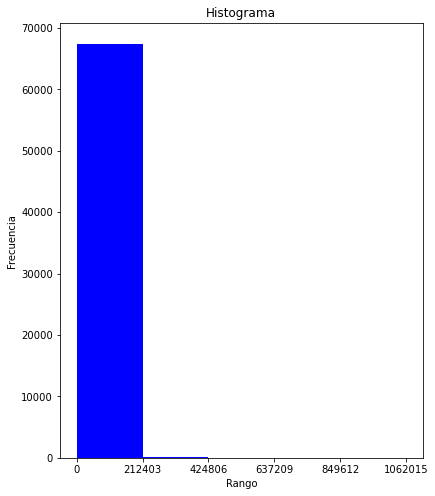

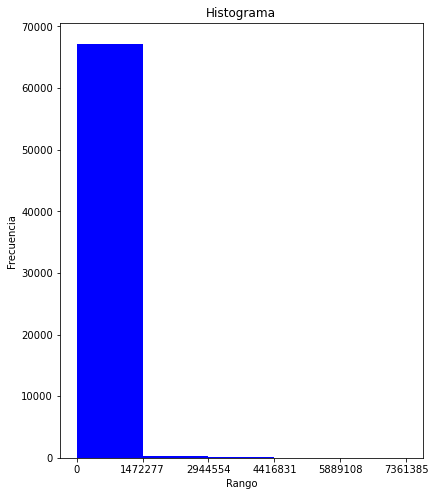

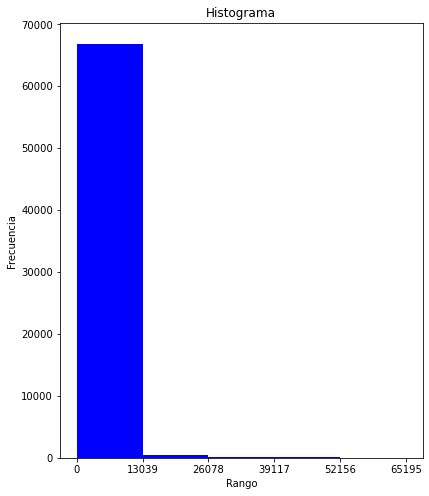

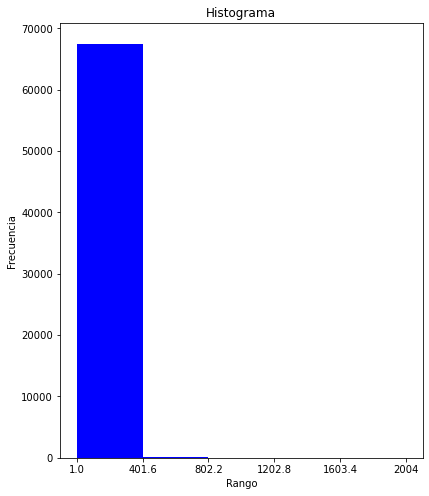

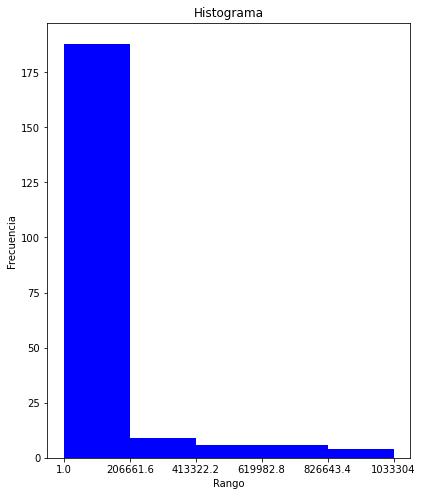

In [29]:
import numpy as np
import matplotlib.pyplot as mplt
import matplotlib.ticker as mtick

def plotHistogramData(data):
    binSides, binCounts = data
    binSides = [round(i, 2) for i in binSides]
    N = len(binCounts)
    ind = np.arange(N)
    width = 1

    fig, ax = mplt.subplots()
    rects1 = ax.bar(ind+0.5, binCounts, width, color='b')
    
    fig.set_size_inches(1.3*N, 8)

    ax.set_ylabel('Frecuencia')
    ax.set_xlabel('Rango')
    ax.set_title('Histograma')
    ax.set_xticks(np.arange(N+1))
    ax.set_xticklabels(binSides)

    mplt.show()

        
plotHistogramData(carga_bordo_hists)
plotHistogramData(carga_ofrecida_hists)
plotHistogramData(pasajeros_hists)
plotHistogramData(vuelos_hists)
plotHistogramData(numero_vuelos_origen_hists)

En relación a las variables analizadas, observamos que no contamos con distribuciones normales para ninguna de las variables

### 3.4 Conclusiones sobre la completitud de la información

En relación con la completitud encontramos que dentro de la información actualmente:

    Existe pero no se conoce o no existe.
    - Información de cógidos IATA para registros faltantes en la fuente aeropuertos
    
    No se sabe si el dato existe.
    - Datos faltantes mencionados en el análisis de este documento

### 4. Viabilidad de realizar los análisis solicitados por el cliente


Dentro del archivo fuente vuelos se identifica que solo se encuentra información de vuelos nacionales. Sin embargo, dada la cantidad de valores nulos identificados es necesario revisar si dentro de estos valores nulos se encuentra la información de vuelos internacionales. Por lo anterior, el análisis de todas las solicitudes del cliente relacionadas con información de vuelos internacionales, por ahora no es posible realizarlo. 

- El número de pasajeros transportados en un rango de fechas de aeropuertos Internacionales a Colombia.
- La carga transportada en un rango de fechas de aeropuertos Internacionales a Colombia.
- La carga desaprovechada en un rango de fechas de aeropuertos Internacionales a Colombia.
- El número de puestos desaprovechados en un rango de fechas de aeropuertos Internacionales a Colombia.
- El porcentaje de cobertura Internacional, por rango de fechas, nacional o regional por departamentos de Colombia.

Los siguientes análisis es posible realizarlos con la información suministrada:
- El número de pasajeros transportados en un rango de fechas de aeropuertos Nacionales de Colombia. 
- La carga transportada en un rango de fechas de aeropuertos Nacionales de Colombia.
- La cantidad de pasajeros salientes y entrantes a través del tiempo por departamentos de Colombia.
- La cantidad de carga aérea saliente y entrante a través del tiempo por departamentos de Colombia.

In [33]:
vuelos.toPandas().to_csv("vuelos2.csv")

In [30]:
vuelos.toPandas().to_csv("aeropuertos2.csv")